In [1]:
# ========================================
# 1. Install dependencies (if needed)
# ========================================
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.5 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:

# ========================================
# 2. Imports
# ========================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models

import numpy as np
from collections import Counter
from imblearn.over_sampling import ADASYN   # ✅ replaced SMOTE with ADASYN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ========================================
# 3. Device
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
train_dir = "/kaggle/input/plants-dataset/CropsData/train"
test_dir  = "/kaggle/input/plants-dataset/CropsData/test"

In [6]:
# ========================================
# 5. Transforms & Dataset
# ========================================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize', 'Healthy Wheat', 'Healthy cotton', 'Leaf Curl', 'Leaf smut', 'Mosaic sugarcane', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'Tungro', 'Wheat Brown leaf Rust', 'Wheat Stem fly', 'Wheat aphid', 'Wheat black rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane', 'bacterial_blight in Cotton', 'bollworm on Cotton', 'cotton mealy bug', 'cotton whitefly', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'pink bollworm in cotton', 'red cotton bug', 'thirps on  cotton']


In [8]:
# ========================================
# 6. Feature Extraction (MobileNetV2)
# ========================================
feature_extractor = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
feature_extractor.classifier = nn.Identity()  # remove classifier
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract train features
features, labels = [], []
with torch.no_grad():
    for imgs, lbls in train_loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)
        features.append(feats.cpu().numpy())
        labels.append(lbls.numpy())

X_train = np.vstack(features)
y_train = np.hstack(labels)

print("Train feature shape:", X_train.shape)
print("Original class distribution:", Counter(y_train))


Train feature shape: (15369, 1280)
Original class distribution: Counter({0: 375, 1: 375, 2: 375, 3: 375, 4: 375, 5: 375, 6: 375, 7: 375, 8: 375, 9: 375, 10: 375, 11: 375, 13: 375, 14: 375, 15: 375, 16: 375, 17: 375, 18: 375, 19: 375, 20: 375, 21: 375, 22: 375, 23: 375, 24: 375, 25: 375, 26: 375, 27: 375, 28: 375, 29: 375, 30: 375, 31: 375, 32: 375, 33: 375, 34: 375, 35: 375, 37: 375, 38: 375, 39: 375, 40: 375, 12: 374, 36: 370})


In [10]:
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter

print("Before oversampling:", Counter(y_train))

try:
    # Try ADASYN first
    adasyn = ADASYN(random_state=42, sampling_strategy="auto")
    X_res, y_res = adasyn.fit_resample(X_train, y_train)
    
    print("After ADASYN class distribution:", Counter(y_res))

except ValueError as e:
    print("ADASYN failed:", e)
    print("Falling back to SMOTE...")
    
    smote = SMOTE(random_state=42, sampling_strategy="auto")
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    print("After SMOTE class distribution:", Counter(y_res))


Before oversampling: Counter({0: 375, 1: 375, 2: 375, 3: 375, 4: 375, 5: 375, 6: 375, 7: 375, 8: 375, 9: 375, 10: 375, 11: 375, 13: 375, 14: 375, 15: 375, 16: 375, 17: 375, 18: 375, 19: 375, 20: 375, 21: 375, 22: 375, 23: 375, 24: 375, 25: 375, 26: 375, 27: 375, 28: 375, 29: 375, 30: 375, 31: 375, 32: 375, 33: 375, 34: 375, 35: 375, 37: 375, 38: 375, 39: 375, 40: 375, 12: 374, 36: 370})
ADASYN failed: No samples will be generated with the provided ratio settings.
Falling back to SMOTE...
After SMOTE class distribution: Counter({0: 375, 1: 375, 2: 375, 3: 375, 4: 375, 5: 375, 6: 375, 7: 375, 8: 375, 9: 375, 10: 375, 11: 375, 12: 375, 13: 375, 14: 375, 15: 375, 16: 375, 17: 375, 18: 375, 19: 375, 20: 375, 21: 375, 22: 375, 23: 375, 24: 375, 25: 375, 26: 375, 27: 375, 28: 375, 29: 375, 30: 375, 31: 375, 32: 375, 33: 375, 34: 375, 35: 375, 36: 375, 37: 375, 38: 375, 39: 375, 40: 375})


In [11]:
# ========================================
# 8. Convert to TensorDataset
# ========================================
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res, dtype=torch.long)

train_resampled_dataset = TensorDataset(X_tensor, y_tensor)
train_resampled_loader  = DataLoader(train_resampled_dataset, batch_size=32, shuffle=True)

In [12]:
# ========================================
# 9. Classifier Model
# ========================================
classifier = nn.Sequential(
    nn.Linear(X_res.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(class_names))
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)


In [13]:
# ========================================
# 10. Training Loop
# ========================================
EPOCHS = 5
for epoch in range(EPOCHS):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0

    for feats, lbls in train_resampled_loader:
        feats, lbls = feats.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = classifier(feats)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += lbls.size(0)
        correct += preds.eq(lbls).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {running_loss/len(train_resampled_loader):.4f} | Accuracy: {acc:.2f}%")


Epoch [1/5] | Loss: 1.3041 | Accuracy: 63.00%
Epoch [2/5] | Loss: 0.6340 | Accuracy: 80.55%
Epoch [3/5] | Loss: 0.4924 | Accuracy: 84.38%
Epoch [4/5] | Loss: 0.4121 | Accuracy: 86.78%
Epoch [5/5] | Loss: 0.3478 | Accuracy: 88.44%



--- Test Results ---
Accuracy : 0.8942232630757221
Precision: 0.9012331459963625
Recall   : 0.8941526357199054
F1-score : 0.8931944825664986

Classification Report:
                              precision    recall  f1-score   support

American Bollworm on Cotton       0.60      0.80      0.68       125
      Anthracnose on Cotton       0.97      0.89      0.93       125
                  Army worm       0.99      0.87      0.93       125
   Becterial Blight in Rice       0.88      0.97      0.92       125
                  Brownspot       0.90      0.96      0.93       125
                Common_Rust       0.96      0.95      0.96       125
               Cotton Aphid       0.96      0.92      0.94       125
                  Flag Smut       0.92      0.92      0.92       125
             Gray_Leaf_Spot       0.95      0.94      0.94       125
              Healthy Maize       0.99      0.98      0.99       125
              Healthy Wheat       0.94      0.82      0.88       125
    

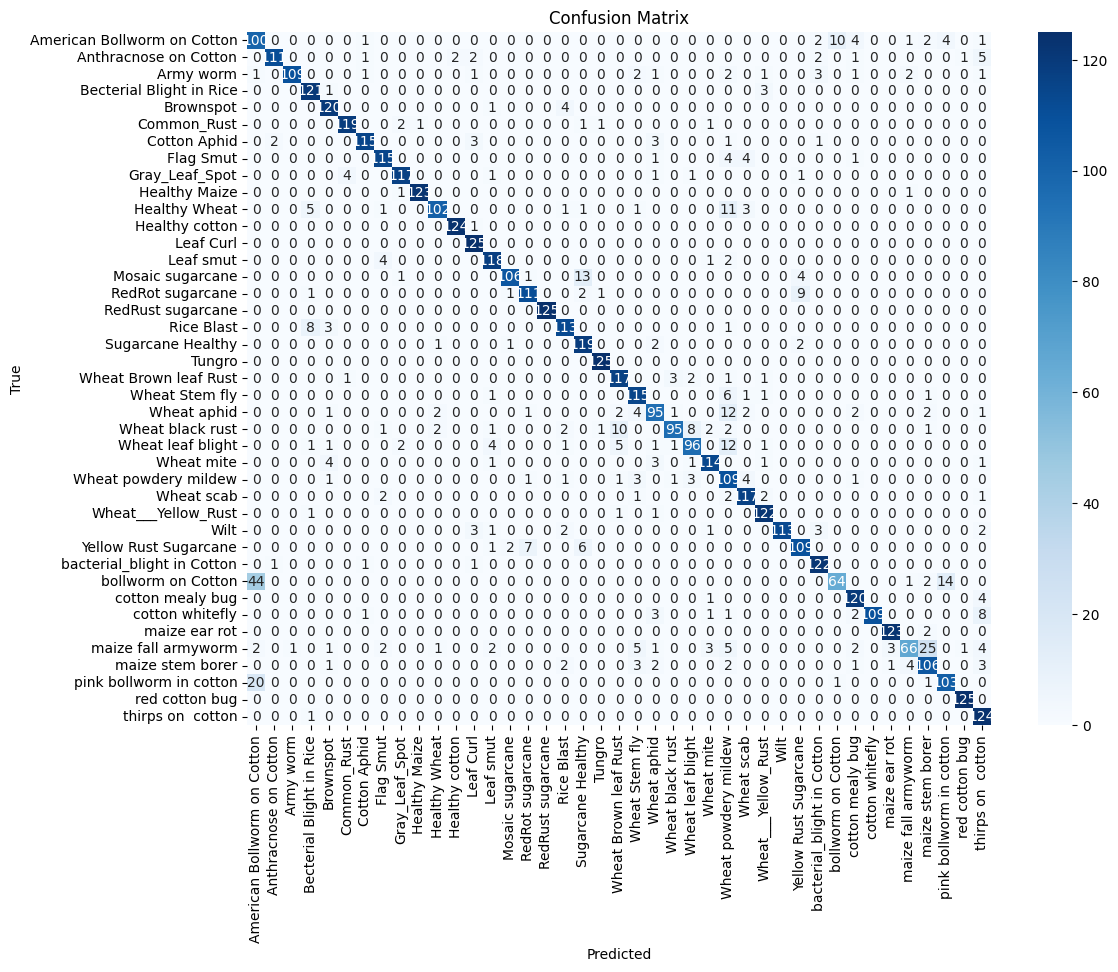

In [15]:
# ========================================
# 11. Evaluation on Test Set
# ========================================
classifier.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)  # extract features
        outputs = classifier(feats)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(lbls.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Test Results ---")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
